<a href="https://colab.research.google.com/github/cateto/python4NLP/blob/main/transformer/Transformer_tensorflow%EB%A1%9C_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 포지셔널 인코딩 구현

In [63]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
  
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles
  
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                 i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                 d_model=d_model)
    
    # 배열의 짝수 인덱스 (2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    
    #배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])
    
    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]  

tf.Tensor(
[[[ 0.          1.          0.         ...  1.          0.
    1.        ]
  [ 0.84147102  0.54030228  0.76172042 ...  1.          0.00011548
    1.        ]
  [ 0.90929741 -0.41614681  0.98704624 ...  0.99999994  0.00023096
    1.        ]
  ...
  [ 0.12357312 -0.9923355   0.13991888 ...  0.99998033  0.00542745
    0.99998528]
  [-0.76825464 -0.64014435 -0.66357207 ...  0.9999795   0.00554293
    0.99998462]
  [-0.95375264  0.30059254 -0.99978465 ...  0.99997866  0.0056584
    0.99998397]]], shape=(1, 50, 128), dtype=float64)


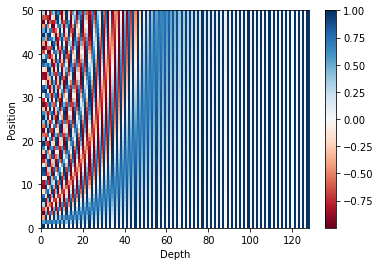

In [64]:
#문장의 길이 50, 벡터의 차원 128
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

인코더의 셀프 어텐션 : Query = Key = Value <br/>
디코더의 마스크드 셀프 어텐션 : Query = Key = Value <br/>
디코더의 인코더-디코더 어텐션 : Query : 디코더 벡터 / Key = Value : 인코더 벡터 <br/>

# 어텐션 구현 (스케일드 닷 프로덕트)

In [65]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Query와 Key의 곱, 어텐션 스코어 행렬
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  
  # 스케일링
  # dk의 루트 값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹, 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다. (입력 문장에 <PAD> 토큰이 있을 경우 어텐션에서 사실상 제외하기 위한 연산)
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트 맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention_weights : (batch_size, num_heads, query의 문장 길이, key의 문장길이)
  attention_weights = tf.nn.softmax(logits, axis = -1)
  
  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [66]:
# 임의의 Query, Key, Value인 Q, K, V 행렬 생성
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]],dtype=tf.float32) #4,3행렬
temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype=tf.float32) # 4,2 행렬
temp_q = tf.constant([[0,10,0]], dtype=tf.float32) #1,3 행렬

In [67]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print("어텐션 분포")
print(temp_attn)
print("어텐션 값")
print(temp_out)

어텐션 분포
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
어텐션 값
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


Query는 4개의 Key값 중 두번째 값과 일치하므로 어텐션 분포는 [0, 1, 0, 0]의 값을 가지며 결과적으로 Value의 두번째 값인 [10, 0]이 출력되는 것을 확인

In [68]:
temp_q = tf.constant([[0,0,10]],dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print("어텐션 분포")
print(temp_attn)
print("어텐션 값")
print(temp_out)

어텐션 분포
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
어텐션 값
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


결과적으로 나오는 값 [550, 5.5]는 Value의 세번째 값 [100, 5]에 0.5를 곱한 값과 네번째 값 [1000, 6]에 0.5를 곱한 값의 원소별 합

In [69]:
temp_q = tf.constant([[0,0,10], 
                      [0,10,0],
                      [10,10,0]], dtype=tf.float32) # 3,3 행렬
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print("어텐션 분포")
print(temp_attn)
print("어텐션 값")
print(temp_out)

어텐션 분포
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
어텐션 값
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# 멀티헤드 어텐션 구현

멀티 헤드 어텐션에서는 크 게 두 종류의 가중치 행렬이 나왔습니다. 바로 Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬입니다. 가중치 행렬을 곱하는 것을 구현 상에서는 입력을 밀집층(Dense layer)를 지나게 하므로서 구현합니다

1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
3. 스케일드 닷 프로덕트 어텐션.
4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
5. WO에 해당하는 밀집층을 지나게 한다.

In [70]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값
    # 논문 기준 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)
  
  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)
    )
    return tf.transpose(inputs, perm=[0,2,1,3])
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로젝트 어텐션
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])

    # 4. 헤드 연결 (concatenate) 하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

패딩을 마스킹한다

In [71]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [72]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


# 인코더 종합


In [73]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  #인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1,1, None), name="padding_mask")

  # 멀티 헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value' : inputs, # 인코더 블럭의 Q=K=V
          'mask' : padding_mask
      })
  # 드롭아웃 + resudial connection과 layer nomalization
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # Position-wise FFNN (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + resudial connection과 layer nomalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

실제로는 num_layers 만큼 쌓게 됨. 그리고 마지막 인코더 층의 output을 디코더로 보내줌.

In [74]:
def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  #인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  #포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers 만큼 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                            dropout=dropout, name="encoder_layer_{}".format(i),
                            )([outputs, padding_mask])
  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 : masked multi-head self attention

트랜스포머에는 총 세 가지 어텐션이 존재하며, 모두 멀티 헤드 어텐션을 수행하고, 멀티 헤드 어텐션 함수 내부에서 스케일드 닷 프로덕트 어텐션 함수를 호출하는데 각 어텐션 시 함수에 전달하는 마스킹은 다음과 같습니다.

- 인코더의 셀프 어텐션 : 패딩 마스크를 전달
- 디코더의 첫번째 서브층인 마스크드 셀프 어텐션 : 룩-어헤드 마스크를 전달 <-- 지금 배우고 있음.
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩 마스크를 전달

In [75]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [76]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


# 디코더 구현

In [77]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 첫번째 서브층에서의 mask (현재 시점 뒤의 단어에 대한 masking)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask"
  )

  # 두번째 서브층에서의 mask (pad된 단어에 대한 masking)
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  # masked multi head self attention
  attention_1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs,
          'mask' : look_ahead_mask
      })
  # add & norm
  attention_1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention_1 + inputs)
  
  # multi head attention
  attention_2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention_1, 'key': enc_outputs, 'value': enc_outputs,
          'mask': padding_mask
      })
  
  # dropout + add & norm
  attention_2 = tf.keras.layers.Dropout(rate=dropout)(attention_2)
  attention_2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention_2 + attention_1)

  # Position wise FFNN
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention_2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # dropout + add & norm
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention_2)
  
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name
  )

In [78]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="decoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # look_ahead_mask & padding_mask
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1,1,None), name="padding_mask")

  # positional encoding + dropout
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # decoder * num_layers
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                            dropout=dropout, name="decoder_layer_{}".format(i),
                            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name
  )

# 트랜스포머 구현

In [79]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):
  # encoder input
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # decoder input
  dec_inputs = tf.keras.Input(shape=(None,),name="dec_inputs")

  # encoder padding mask 
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name='enc_padding_mask')(inputs)
  
  # decoder look ahead mask
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1,None, None),
      name = 'look_ahead_mask')(dec_inputs)
  
  # decoder padding mask
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1,1,None),
      name='dec_padding_mask')(inputs)
  
  # encoder 출력
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                        d_model=d_model, num_heads=num_heads, dropout=dropout,
                        )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩마스크
  # decoder 출력
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
                        d_model=d_model, num_heads=num_heads, dropout=dropout,
                        )(inputs=[dec_inputs,  enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 seq 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)    

# 트랜스포머 기반 모델 생성

tf.Tensor(
[[[ 0.          1.          0.         ...  1.          0.
    1.        ]
  [ 0.84147102  0.54030228  0.76172042 ...  1.          0.00011548
    1.        ]
  [ 0.90929741 -0.41614681  0.98704624 ...  0.99999994  0.00023096
    1.        ]
  ...
  [-0.49805978  0.86714268 -0.06867212 ...  0.36257282  0.86187595
    0.50711912]
  [ 0.46057254  0.88762206  0.71560138 ...  0.36244848  0.86193448
    0.5070197 ]
  [ 0.99575663  0.09202582  0.99573314 ...  0.36232418  0.86199301
    0.5069201 ]]], shape=(1, 9000, 128), dtype=float64)
tf.Tensor(
[[[ 0.          1.          0.         ...  1.          0.
    1.        ]
  [ 0.84147102  0.54030228  0.76172042 ...  1.          0.00011548
    1.        ]
  [ 0.90929741 -0.41614681  0.98704624 ...  0.99999994  0.00023096
    1.        ]
  ...
  [-0.49805978  0.86714268 -0.06867212 ...  0.36257282  0.86187595
    0.50711912]
  [ 0.46057254  0.88762206  0.71560138 ...  0.36244848  0.86193448
    0.5070197 ]
  [ 0.99575663  0.09202582  0

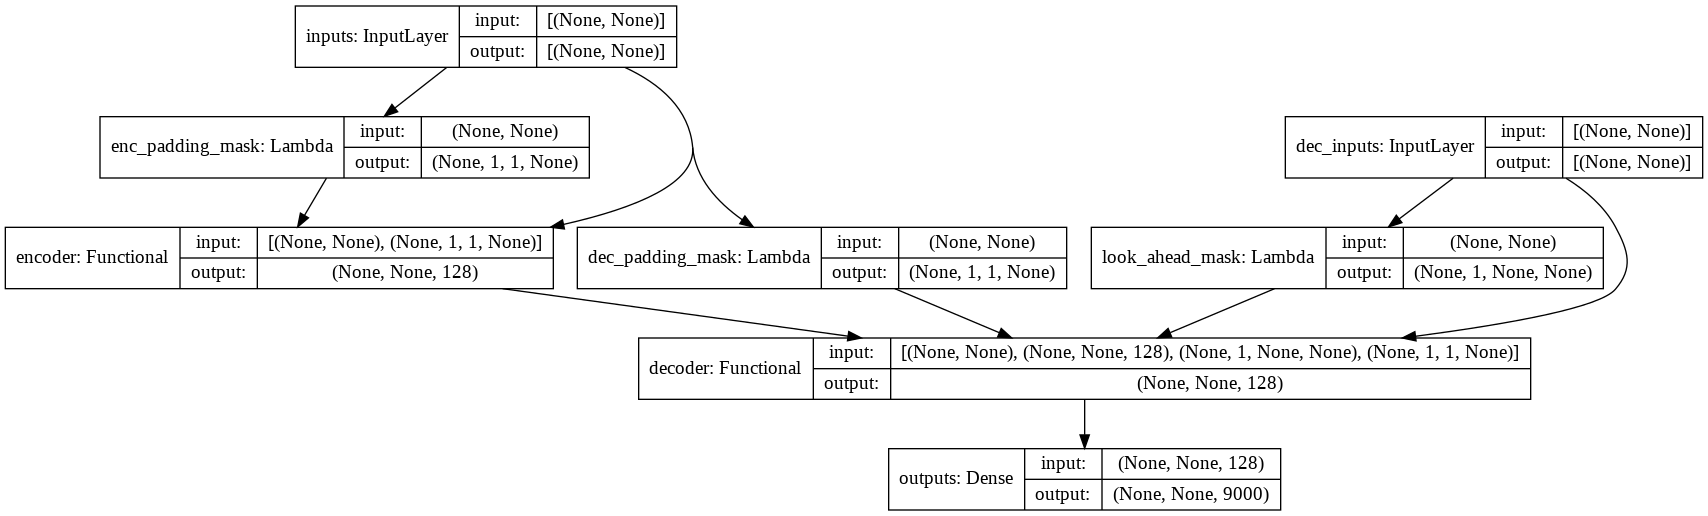

In [80]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name = "small_transformer"
)

tf.keras.utils.plot_model(
    small_transformer, to_file="small_transformer.png", show_shapes=True
)

In [81]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH -1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
  
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [82]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

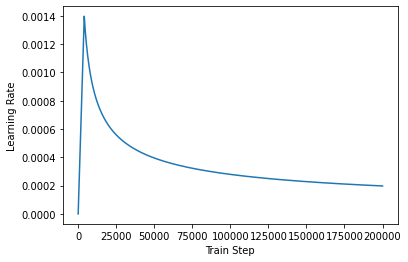

In [83]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")